In [1]:
import sim
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

if clientID != -1:
    print('Connected')

    # Now try to retrieve data in a blocking fashion (i.e. a service call):
    res, objs = sim.simxGetObjects(clientID, sim.sim_handle_all, sim.simx_opmode_blocking)

    print('Simulation time in milliseconds: ', sim.simxGetLastCmdTime(clientID))
    
    # Get Object position
    name = 'Omnirob'
    err_code, cuboid = sim.simxGetObjectHandle(clientID, name, sim.simx_opmode_blocking)
    res, position = sim.simxGetObjectPosition(clientID, cuboid, -1, sim.simx_opmode_blocking)        
    print('Omnirob is at [x,y,z]=', position)
    
    # Now close the connection to CoppeliaSim:
    sim.simxGetPingTime(clientID)
    sim.simxFinish(clientID)
    print('Disconnected')
else:
    print('Failed connecting to remote API server')

Connected
Simulation time in milliseconds:  12100
Omnirob is at [x,y,z]= [7.624996185302734, 8.548980712890625, 0.3544991612434387]
Disconnected


In [3]:
class robot():
    
    def __init__(self, frame_name, motor_names=[], client_id=0):  
        # If there is an existing connection
        if client_id:
                self.client_id = client_id
        else:
            self.client_id = self.open_connection()
            
        self.motors = self._get_handlers(motor_names) 
        
        # Robot frame
        self.frame =  self._get_handler(frame_name)
            
        
    def open_connection(self):
        sim.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim 
        
        if clientID != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return clientID
        
    def close_connection(self):    
        sim.simxGetPingTime(self.client_id)  # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive.
        sim.simxFinish(self.client_id)  # Now close the connection to CoppeliaSim:
        print('Connection closed')
    
    def isConnected(self):
        c,result = sim.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0         
        
    def _get_handler(self, name):
        err_code, handler = sim.simxGetObjectHandle(self.client_id, name, sim.simx_opmode_blocking)
        return handler
    
    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)
        
        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = sim.simxSetJointTargetVelocity(self.client_id, 
                                                      motor, vel, sim.simx_opmode_streaming)      
            
    def set_position(self, position, relative_object=-1):
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)        
        sim.simxSetObjectPosition(clientID, self.frame, relative_object, position, sim.simx_opmode_oneshot)
        
    def simtime(self):
        return sim.simxGetLastCmdTime(self.client_id)
    
    def get_position(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, position = sim.simxGetObjectPosition(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)        
        return array(position)
    
    def get_object_position(self, object_name):
        # Get Object position in the world frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        return array(position)
    
    def get_object_relative_position(self, object_name):        
        # Get Object position in the robot frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, self.frame, sim.simx_opmode_blocking)
        return array(position)

In [4]:
def point_to_point_traj(x1, x2, v1, v2, delta_t):
    t = np.linspace(0, delta_t, 100)  
    a0 = x1
    a1 = v1
    a2 = (3*x2 - 3*x1 - 2*v1*delta_t - v2 * delta_t) / (delta_t**2)
    a3 = (2*x1 + (v1 + v2) * delta_t  - 2 * x2) / (delta_t**3)

    polynomial = a0 + a1 * t + a2 * t**2 + a3 * t**3
    derivative = a1 + 2*a2 * t + 3 * a3 * t**2
    print('a0: (%.4f) '%(a0))
    print('a1: (%.4f) '%(a1))
    print('a2: (%.4f) '%(a2))
    print('a3: (%.4f) '%(a3))
    return polynomial, derivative

def a_pairs(x1, x2, v1, v2, delta_t):
    t = np.linspace(0, delta_t, 100)  
    a0 = x1
    a1 = v1
    a2 = (3*x2 - 3*x1 - 2*v1*delta_t - v2 * delta_t) / (delta_t**2)
    a3 = (2*x1 + (v1 + v2) * delta_t  - 2 * x2) / (delta_t**3)

    #print('a0: (%.4f) '%(a0))
    #print('a1: (%.4f) '%(a1))
    #print('a2: (%.4f) '%(a2))
    #print('a3: (%.4f) '%(a3))
    return a0, a1, a2, a3

def piecewise2D (X,Y, Vx, Vy, T):
    theta_x, theta_y, dx, dy = [], [], [], []
    a0_pairs = []
    a1_pairs = []
    a2_pairs = []
    a3_pairs = []

    
    count = 1
    for i in range(len(P)-1):
        print(count)
        count = count+1
        print('x')
        theta_xi, dxi = point_to_point_traj(X[i], X[i+1], Vx[i], Vx[i+1], T[i+1] - T[i])
        xa0, xa1, xa2, xa3 = a_pairs(X[i], X[i+1], Vx[i], Vx[i+1], T[i+1] - T[i])
        print('y')
        theta_yi, dyi = point_to_point_traj(Y[i], Y[i+1], Vy[i], Vy[i+1], T[i+1] - T[i])
        ya0, ya1, ya2, ya3 = a_pairs(Y[i], Y[i+1], Vy[i], Vy[i+1], T[i+1] - T[i])
        print('=================')
        
        a0_pairs.append([xa0, ya0])
        a1_pairs.append([xa1, ya1])
        a2_pairs.append([xa2, ya2])
        a3_pairs.append([xa3, ya3])
        
        theta_x += theta_xi.tolist()
        theta_y += theta_yi.tolist()
        dx += dxi.tolist()
        dy += dyi.tolist()

        plot(theta_xi, theta_yi)
    return theta_x, theta_y, dx, dy, a0_pairs, a1_pairs, a2_pairs, a3_pairs

# Plotting
def plot_points():
    plot(X,Y, '--')
    plot(X,Y, 'o')
    quiver(X,Y, Vx, Vy, color='r')

def plot_points_3d():
    plot(X,Y,Z, '--')
    plot(X,Y,Z, 'o')
    
# Speed
def plot_speed():
    speed = np.sqrt(np.array(dx)**2 + np.array(dy)**2)
    plot(speed)

83
1
x
a0: (7.8349) 
a1: (0.0000) 
a2: (-0.0460) 
a3: (0.0020) 
y
a0: (6.0677) 
a1: (0.0000) 
a2: (0.0081) 
a3: (-0.0003) 
2
x
a0: (5.2061) 
a1: (-0.3286) 
a2: (0.0320) 
a3: (-0.0018) 
y
a0: (6.5304) 
a1: (0.0578) 
a2: (-0.0344) 
a3: (0.0016) 
3
x
a0: (3.2800) 
a1: (-0.2408) 
a2: (0.0177) 
a3: (-0.0011) 
y
a0: (5.2284) 
a1: (-0.1628) 
a2: (0.0319) 
a3: (-0.0016) 
4
x
a0: (1.5385) 
a1: (-0.2177) 
a2: (0.0099) 
a3: (-0.0007) 
y
a0: (5.1933) 
a1: (-0.0044) 
a2: (-0.0171) 
a3: (0.0007) 
5
x
a0: (-0.3838) 
a1: (-0.2403) 
a2: (0.0312) 
a3: (-0.0017) 
y
a0: (4.1677) 
a1: (-0.1282) 
a2: (0.0102) 
a3: (-0.0006) 
6
x
a0: (-1.3493) 
a1: (-0.1207) 
a2: (0.0041) 
a3: (-0.0004) 
y
a0: (3.2849) 
a1: (-0.1104) 
a2: (0.0189) 
a3: (-0.0010) 
7
x
a0: (-2.4917) 
a1: (-0.1428) 
a2: (0.0068) 
a3: (-0.0005) 
y
a0: (3.1035) 
a1: (-0.0227) 
a2: (-0.0081) 
a3: (0.0003) 
8
x
a0: (-3.7353) 
a1: (-0.1555) 
a2: (0.0296) 
a3: (-0.0015) 
y
a0: (2.3791) 
a1: (-0.0905) 
a2: (-0.0082) 
a3: (0.0002) 
9
x
a0: (-3.8226) 
a

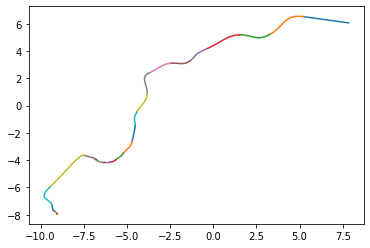

In [5]:
##Calculate Trajectories
##### Requirements for the trajectory
#c_path calculated: 
c_path1 = [[7.8349, 6.0677], [5.2061, 6.5304], [3.28, 5.2284], [1.5385, 5.1933], [-0.3838, 4.1677], [-1.3493, 3.2849], [-2.4917, 3.1035], [-3.7353, 2.3791], [-3.8226, 0.8779], [-4.4305, -0.4913], [-4.5172, -1.4896], [-4.7006, -2.6319], [-5.2095, -3.4949], [-5.6452, -3.9725], [-5.9917, -4.1437], [-6.2729, -4.168], [-6.4756, -4.1471], [-6.5939, -4.1104], [-6.6567, -4.0707], [-6.6961, -4.0359], [-6.7265, -4.0069], [-6.753, -3.9819], [-6.7777, -3.9593], [-6.8023, -3.9378], [-6.8278, -3.9164], [-6.8556, -3.8941], [-6.8874, -3.87], [-6.9257, -3.8429], [-6.9742, -3.8113], [-7.0396, -3.7737], [-7.1332, -3.7283], [-7.2764, -3.6769], [-7.5039, -3.6349], [-7.8488, -3.6558], [-8.2737, -3.8253], [-8.6614, -4.1495], [-8.9526, -4.5396], [-9.1608, -4.9322], [-9.3049, -5.306], [-9.3971, -5.6516], [-9.4485, -5.9635], [-9.4698, -6.2395], [-9.4704, -6.4806], [-9.4571, -6.6894], [-9.4353, -6.8692], [-9.4085, -7.0235], [-9.3792, -7.1556], [-9.3492, -7.2687], [-9.3196, -7.3654], [-9.2912, -7.4481], [-9.2643, -7.5188], [-9.2393, -7.5792], [-9.2162, -7.6309], [-9.1951, -7.6752], [-9.176, -7.7131], [-9.1587, -7.7456], [-9.1432, -7.7735], [-9.1293, -7.7974], [-9.1169, -7.8179], [-9.1059, -7.8355], [-9.0961, -7.8507], [-9.0874, -7.8638], [-9.0798, -7.875], [-9.073, -7.8847], [-9.0671, -7.893], [-9.0618, -7.9002], [-9.0572, -7.9065], [-9.0532, -7.9118], [-9.0497, -7.9165], [-9.0466, -7.9205], [-9.0439, -7.924], [-9.0415, -7.927], [-9.0394, -7.9295], [-9.0376, -7.9318], [-9.036, -7.9337], [-9.0347, -7.9354], [-9.0335, -7.9369], [-9.0324, -7.9382], [-9.0315, -7.9393], [-9.0307, -7.9402], [-9.03, -7.941], [-9.0294, -7.9417], [-9.0289, -7.9424]]
#speedup
print(len(c_path1))
c_path = []
for c_index in range(0,len(c_path1)):
    if(c_index<28):
        c_path.append(c_path1[c_index])
    elif(c_index % 8 == 0):
        c_path.append(c_path1[c_index])

# Velocities
vs = [[0,0]]
for c_index in range(0,len(c_path)-1):
    rn = c_path[c_index]
    fut = c_path[c_index+1]
    xs = fut[0]-rn[0]
    ys = fut[1]-rn[1]
    if xs != 0:
        xs = xs/8
    if ys != 0:
        ys = ys/8
    vs.append([xs,ys])

    
# Time
ts = []
for tim in range(0,len(c_path)):
    ts.append(tim*10)

# Grouping
#P = np.vstack((p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13, p14, p15, p16, p17))
#V = np.vstack((v1, v2, v3, v4, v5, v6, v7, v8, v9, v10, v11, v12, v13, v14, v15, v16, v17))
#T = [t1, t2, t3, t4, t5, t6, t7, t8, t9, t10, t11, t12, t13, t14, t15, t16, t17]
P = np.vstack(c_path)
V = np.vstack(vs)
T = ts
X, Y = P[:,0], P[:,1]
Vx, Vy = V[:,0], V[:,1]

# Plotting
#plot_points()
#show()

# Piecewise function
theta_x, theta_y, dx, dy, a0_pairs, a1_pairs, a2_pairs, a3_pairs = piecewise2D(X,Y, Vx,Vy, T)

In [6]:
# Joint name in coppelia
motor_names = ['Omnirob_FLwheel_motor', 'Omnirob_FRwheel_motor', 'Omnirob_RRwheel_motor', 'Omnirob_RLwheel_motor']
r = robot('Omnirob', motor_names)  # Create an instance of our robot

# Initial locations
robot_position = r.get_position()
print('Robot position: (%.2f, %.2f) '%(robot_position[0], robot_position[1]))

# Virtual disk
disk = robot('Disc', client_id=r.client_id)

# Time duration
tf = 10
# Time interval
time_steps = linspace(0, tf, 100)

count = 0
for wp in T:  
    print("Count: ",count)
    a0 = a0_pairs[count]
    a1 = a1_pairs[count]
    a2 = a2_pairs[count]
    a3 = a3_pairs[count]
    print('a0: %s'%(a0))
    print('a1: %s'%(a1))
    print('a2: %s'%(a2))
    print('a3: %s'%(a3))

    for t in time_steps:
        # Compute trajectory
        x_point_traj = a0[0] + a1[0]*t + a2[0]*(t**2) + a3[0]*(t**3) #Gamma_x
        x_vel_traj = a1[0] + 2*a2[0]*t + 3*a3[0]*(t**2) #Derivative of Gamma_x
        y_point_traj = a0[1] + a1[1]*t + a2[1]*(t**2) + a3[1]*(t**3) #Gamma_y
        y_vel_traj = a1[1] + 2*a2[1]*t + 3*a3[1]*(t**2) #Derivative of Gamma_y
        #print('(%.4f,%.4f)' %(x_point_traj, y_point_traj))

        disk.set_position([x_point_traj, y_point_traj])

        # Sensing
        robot_position = r.get_position()

        # Trajectory tracker
        u = 10 * (np.array([x_point_traj, y_point_traj, 0]) - robot_position) + np.array([x_vel_traj, y_vel_traj, 0])

        vx, vy, vz = u
        r.send_motor_velocities([-vy - vx, vy - vx, vy + vx, -vy + vx])

        time.sleep(tf/2000)
    
    count+=1

    r.send_motor_velocities([0,0,0,0])
r.close_connection()

Robot connected
Robot position: (7.62, 8.55) 
Robot connected
Count:  0
a0: [7.8349, 6.0677]
a1: [0.0, 0.0]
a2: [-0.04600399999999999, 0.008097250000000016]
a3: [0.0019716000000000004, -0.00034702500000000037]
Count:  1
a0: [5.2061, 6.5304]
a1: [-0.3286, 0.057837499999999986]
a2: [0.032013249999999986, -0.034352500000000015]
a3: [-0.0018414249999999992, 0.001554875000000001]
Count:  2
a0: [3.28, 5.2284]
a1: [-0.24076250000000005, -0.16275000000000006]
a2: [0.017676250000000008, 0.03193575000000001]
a3: [-0.0011015000000000005, -0.0016011750000000013]
Count:  3
a0: [1.5385, 5.1933]
a1: [-0.21768749999999998, -0.004387499999999989]
a2: [0.00989725, -0.017070499999999992]
a3: [-0.0007351499999999998, 0.0007253249999999998]
Count:  4
a0: [-0.3838, 4.1677]
a1: [-0.2402875, -0.12819999999999998]
a2: [0.031161249999999995, 0.01019099999999999]
a3: [-0.00167875, -0.0006199000000000004]
Count:  5
a0: [-1.3493, 3.2849]
a1: [-0.1206875, -0.11035]
a2: [0.004145500000000011, 0.0188955]
a3: [-0.0003

IndexError: list index out of range